In [11]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np

snscolors = sns.color_palette("colorblind")

In [2]:
from cosmicfishpie.fishermatrix import cosmicfish

In [3]:
fiducial = {
    "Omegam": 0.32,
    "Omegab": 0.05,
    "h": 0.67,
    "ns": 0.96,
    "sigma8": 0.815584,
    "w0": -1.0,
    "wa": 0.0,
    "mnu": 0.06,
    "Neff": 3.044,
}

options = {
    "accuracy": 1,
    "feedback": 1,
    "code": "camb",
    "outroot": "GCsp_presentation",
    "survey_name": "Euclid",
    "survey_name_spectro": "Euclid-Spectroscopic-ISTF-Pessimistic",
    "cosmo_model": "w0waCDM",
    "bfs8terms": False,
    "vary_bias_str": "b",
}

In [4]:
observables = ["GCsp"]

### Pass options and settings to Cosmicfishpie

We set the survey to `Euclid-Spectroscopic-ISTF-Pessimistic` setting the default settings for the galaxy biases, modeling choices for red shift space distortions and computation of non-linearity

In [5]:
cosmoFM_A = cosmicfish.FisherMatrix(
    fiducialpars=fiducial,
    options=options,
    observables=observables,
    cosmoModel=options["cosmo_model"],
    surveyName=options["survey_name"],
)

**************************************************************
   _____               _     _____     __  
  / ___/__  ___ __ _  (_)___/ __(_)__ / /  
 / /__/ _ \(_-</  ' \/ / __/ _// (_-</ _ \ 
 \___/\___/___/_/_/_/_/\__/_/ /_/___/_//_/ 

**************************************************************
 This is the new Python version of the CosmicFish code.
**************************************************************
Custom fiducial parameters loaded

  -> Computing cosmology at the fiducial point

  ---> Cosmological functions obtained in:   5.87 s


# Spectroscopic Power Spectrum

The observed power spectrum of galaxies can be related to the mater power spectrum by 

$$
P^\mathrm{th} = q_\| \times  q_\perp^2 \times K \times \mathrm{FoG} \times \mathrm{Err} \times P_{mm} + P^\mathrm{shot}.
$$
The factors in front are due to different observational effects. The factor $q_\|$ and $q_\perp$ are coming from the fact that we can only observe the redshift of galaxies and not their position.
To calculate the power spectrum we have to settle for a reference transformation. If this is different from the cosmology we used to compute the power spectrum in, we find 
$$
q_\| = H(z)/H^\mathrm{ref}(z) \quad\text{and}\quad q_\perp = D_A^\mathrm{ref}(z)/D_A(z)
$$

The factors $q_\mathrm{RSD}$ and $q_\mathrm{FOG}$ describe redshift space distortions and are given by
$$
K = \left(b+f\,\mu^2\right)^2\\
\mathrm{FoG} = 1+\left[f\,\sigma_p\,\mu^2\right]^2

$$
where $\mu$ denotes the angle under which we observe the structures.
The factor $q_\sigma$ is due to the resolution of the instrument and is given by
$$
\mathrm{Err} = \exp\left[-\sigma^2_\|\, k^2\, \mu^2 -\sigma_\perp^2 \,k^2\,\left(1- \mu^2\right)\right].
$$
Finaly, $P^\mathrm{shot}$ just is a constant term we add for shot noise.
The nonlinear power spectrum $P_{mm}$ is approximated as 
$$
P_{mm} \approx P_{dw} \coloneqq P_{mm}^\mathrm{lin}\,e^{-g} + P_{mm}\,(1-e^g),\\
g= \sigma_v^2 k^2\, \left((1-\mu^2)+\mu^2(1+f)^2\right)
$$

In [6]:
from cosmicfishpie.LSSsurvey import spectro_obs as spobs

spectro_Pk = spobs.ComputeGalSpectro(cosmoFM_A.fiducialcosmopars)

In [7]:
print(spectro_Pk.spectrobiaspars)
print("bias term at z=1.0: ", spectro_Pk.bterm_fid(1.0, bias_sample="g"))
print("bias term at z=1.2: ", spectro_Pk.bterm_fid(1.2, bias_sample="g"))
print("bias term at z=1.4: ", spectro_Pk.bterm_fid(1.4, bias_sample="g"))
print("bias term at z=1.65: ", spectro_Pk.bterm_fid(1.65, bias_sample="g"))

{'lnbg_1': 0.37944989, 'lnbg_2': 0.4738057, 'lnbg_3': 0.55760176, 'lnbg_4': 0.64125687}
bias term at z=1.0:  1.4614803932771856
bias term at z=1.2:  1.606094892470849
bias term at z=1.4:  1.7464789980013922
bias term at z=1.65:  1.89886600781197


### "De-wiggling" of the Power Spectrum

To calculate the observed power spectrum we need to dewiggle it to find the non linear correction 

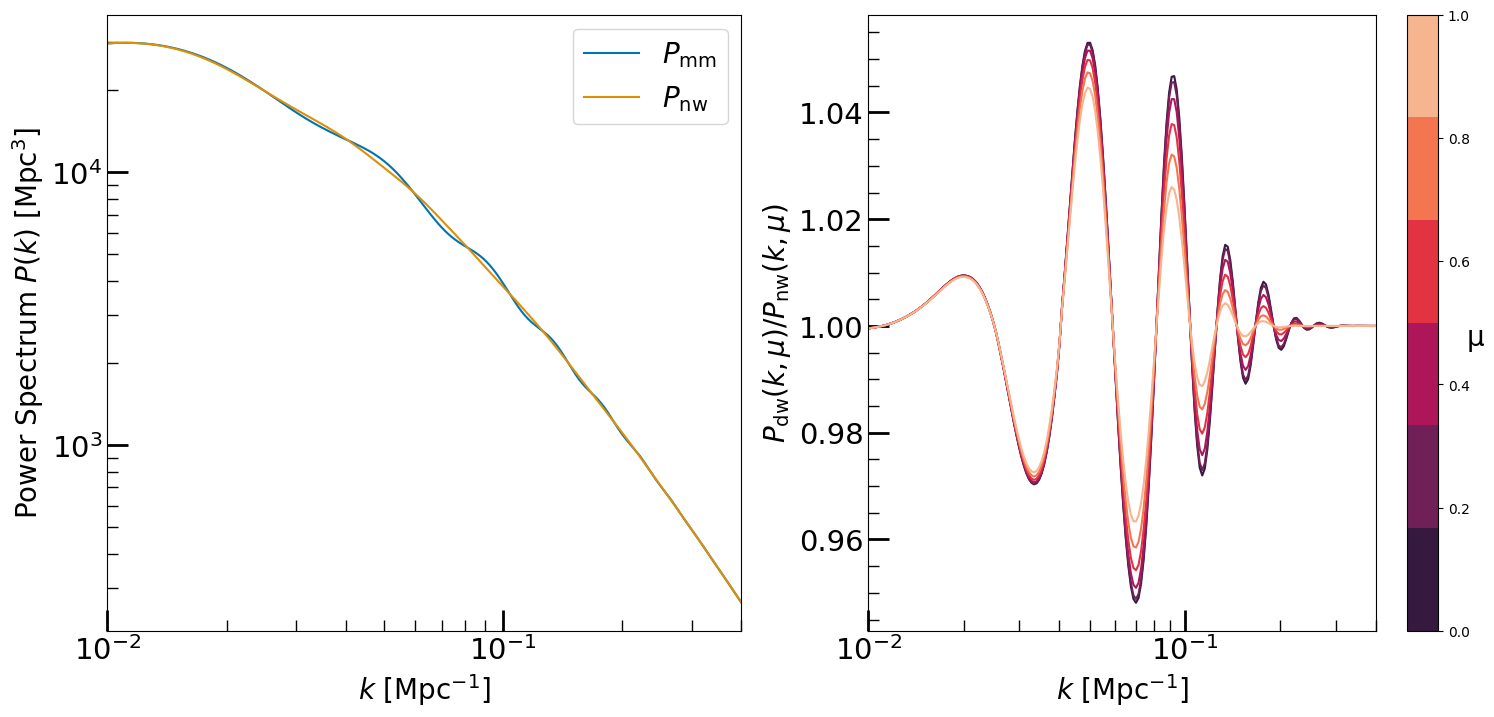

In [9]:

z = 1
kk = np.logspace(-2, np.log10(0.4), 200)

fig, axs = plt.subplots(1, 2, figsize=(18, 8))

color = iter(snscolors)

c = next(color)
axs[0].loglog(kk, spectro_Pk.cosmo.Pmm(z, kk), c=c, label="$P_\mathrm{mm}$")
c = next(color)
axs[0].loglog(kk, spectro_Pk.cosmo.nonwiggle_pow(z, kk), c=c, label="$P_\mathrm{nw}$")
axs[0].set_xlabel(r"$k$ [$\mathrm{Mpc}^{-1}$]", fontsize=20)
axs[0].set_ylabel(r"Power Spectrum $P(k)$ [$\mathrm{Mpc}^{3}$]", fontsize=20)
axs[0].legend(fontsize=20)
axs[0].set_xlim([1e-2, 0.4])

colormap_mu = sns.color_palette("rocket")
colors = iter(colormap_mu)
mus = np.linspace(0, 1, 6)

sm_mu = plt.cm.ScalarMappable(cmap=ListedColormap(colormap_mu), norm=plt.Normalize(vmin=mus.min(), vmax=mus.max()))
sm_mu.set_array([])

for mu in mus:
    c = next(colors)
    axs[1].plot(kk, spectro_Pk.dewiggled_pdd(z, kk, mu) / spectro_Pk.normalized_pnw(z, kk), c=c)

cbar_mu = fig.colorbar(sm_mu, ax=axs[1])
cbar_mu.set_label('μ', fontsize=20, rotation=0)
axs[1].set_xscale("log")
axs[1].set_xlabel(r"$k$ [$\mathrm{Mpc}^{-1}$]", fontsize=20)
axs[1].set_ylabel(r"$P_\mathrm{dw}(k, \mu)$/$P_\mathrm{nw}(k, \mu)$", fontsize=20)
axs[1].set_xlim([1e-2, 0.4])

[ax.tick_params(which="major", length=15, width=2, direction="in") for ax in axs]
[ax.tick_params(which="minor", length=8, width=1, direction="in") for ax in axs]
[ax.minorticks_on() for ax in axs]
[ax.tick_params(axis="both", which="major", labelsize=21) for ax in axs]
[ax.tick_params(axis="both", which="minor", labelsize=15) for ax in axs]

plt.show()

#### Compute the observed power spectrum at different redshifts and different angles 

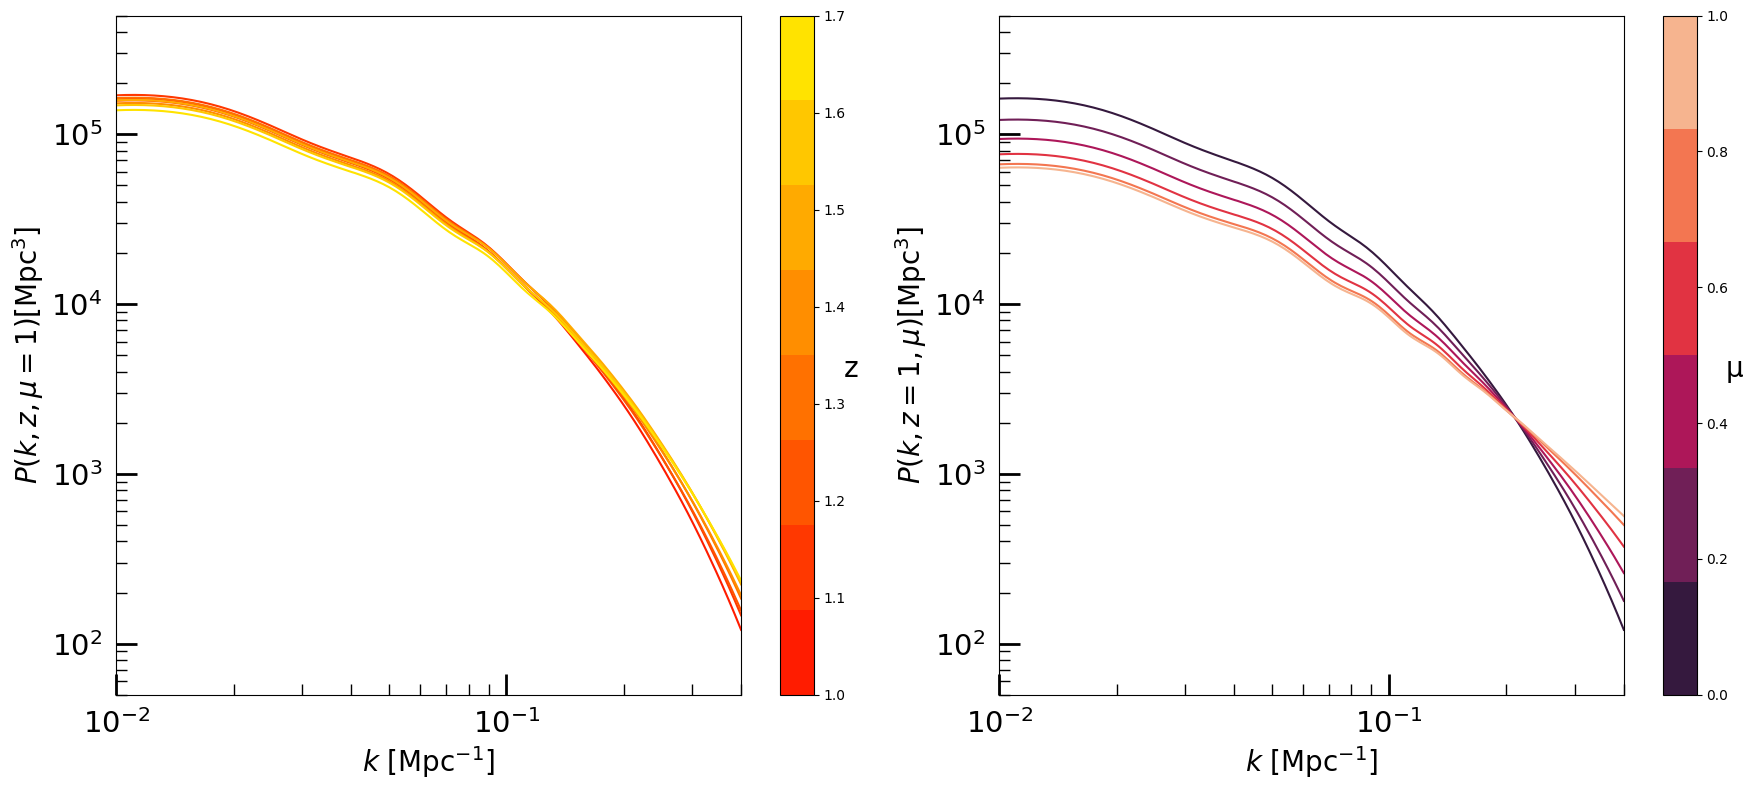

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

colormap_z = sns.color_palette("autumn", 8)
colors_z = iter(colormap_z)
zz = np.linspace(1, 1.7, 8)

sm_z = plt.cm.ScalarMappable(cmap=ListedColormap(colormap_z), norm=plt.Normalize(vmin=zz.min(), vmax=zz.max()))
sm_z.set_array([])

zz = np.linspace(1, 1.7, 8)
for z in zz:
    c = next(colors_z)
    axs[0].loglog(kk, spectro_Pk.observed_Pgg(z, kk, 1), c=c)

axs[0].set_xlabel(r"$k$ [$\mathrm{Mpc}^{-1}$]", fontsize=20)
axs[0].set_ylabel(r"$P(k,z,\mu=1)[\mathrm{Mpc}^3]$", fontsize=20)
axs[0].set_xlim([1e-2, 0.4])
axs[0].set_ylim([5*1e1, 5*1e5])
cbar_z = fig.colorbar(sm_z, ax=axs[0])
cbar_z.set_label('z', fontsize=20, rotation=0)

colormap_mu = sns.color_palette("rocket", 6)
colors_mu = iter(colormap_mu)
mus = np.linspace(1, 0, 6)
sm_mu = plt.cm.ScalarMappable(cmap=ListedColormap(colormap_mu), norm=plt.Normalize(vmin=mus.min(), vmax=mus.max()))
sm_mu.set_array([])

for mu in mus:
    c = next(colors_mu)
    axs[1].loglog(kk, spectro_Pk.observed_Pgg(1, kk, mu), c=c)

axs[1].set_xlabel(r"$k$ [$\mathrm{Mpc}^{-1}$]", fontsize=20)
axs[1].set_ylabel(r"$P(k,z=1,\mu)[\mathrm{Mpc}^3]$", fontsize=20)
axs[1].set_xlim([1e-2, 0.4])
axs[1].set_ylim([5*1e1, 5*1e5])
cbar_mu = fig.colorbar(sm_mu, ax=axs[1])
cbar_mu.set_label('μ', fontsize=20, rotation=0)

[ax.tick_params(which="major", length=15, width=2, direction="in") for ax in axs]
[ax.tick_params(which="minor", length=8, width=1, direction="in") for ax in axs]
[ax.minorticks_on() for ax in axs]
[ax.tick_params(axis="both", which="major", labelsize=21, pad=10) for ax in axs]
[ax.tick_params(axis="both", which="minor", labelsize=15) for ax in axs]
plt.tight_layout()
plt.show()

### Compare the Power Spectrum from two different cosmologies

In [20]:
sample = {
    "Omegam": 0.32,
    "Omegab": 0.06,  # 20% higher than the fiducial
    "h": 0.737,  # 10% higher than the fiducal
    "ns": 0.96,
    "sigma8": 0.815584,
    "w0": -1.0,
    "wa": 0.0,
    "mnu": 0.06,
    "Neff": 3.044,
}

spectro_Pk_sampled = spobs.ComputeGalSpectro(sample, cosmoFM_A.fiducialcosmopars)

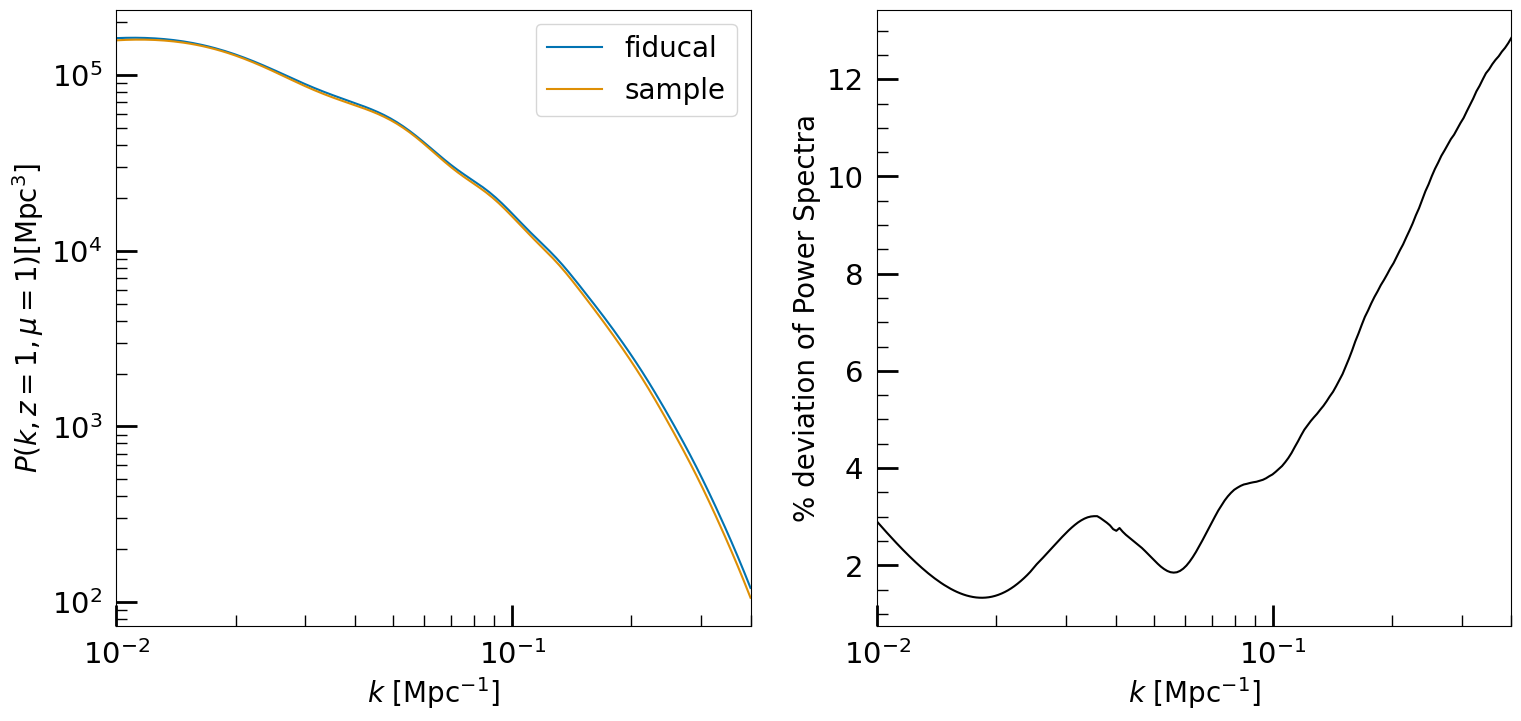

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

colormap = sns.color_palette("colorblind")
colors = iter(colormap)

c = next(colors)
axs[0].loglog(kk, spectro_Pk.observed_Pgg(1, kk, 1), c=c, label="fiducal")

c = next(colors)
axs[0].loglog(kk, spectro_Pk_sampled.observed_Pgg(1, kk, 1), c=c, label="sample")

axs[0].set_xlabel(r"$k$ [$\mathrm{Mpc}^{-1}$]", fontsize=20)
axs[0].set_ylabel(r"$P(k,z=1,\mu=1)[\mathrm{Mpc}^3]$", fontsize=20)
axs[0].set_xlim([1e-2, 0.4])
axs[0].legend(fontsize=20)
axs[0].set_xscale("log")

axs[1].plot(
    kk,
    (spectro_Pk.observed_Pgg(1, kk, 1) - spectro_Pk_sampled.observed_Pgg(1, kk, 1))
    / (spectro_Pk.observed_Pgg(1, kk, 1) + spectro_Pk_sampled.observed_Pgg(1, kk, 1))
    * 200,
    c="black",
)

axs[1].set_xlabel(r"$k$ [$\mathrm{Mpc}^{-1}$]", fontsize=20)
axs[1].set_ylabel(r"% deviation of Power Spectra", fontsize=20)
axs[1].set_xlim([1e-2, 0.4])
axs[1].set_xscale("log")

[ax.tick_params(which="major", length=15, width=2, direction="in") for ax in axs]
[ax.tick_params(which="minor", length=8, width=1, direction="in") for ax in axs]
[ax.minorticks_on() for ax in axs]
[ax.tick_params(axis="both", which="major", labelsize=21, pad=10) for ax in axs]
[ax.tick_params(axis="both", which="minor", labelsize=15) for ax in axs]

plt.show()